# Predicting regional differences in proportion diagnosed and positivity

In this example, we assume that the incidence of chlamydia is homoegeneous across England and investigate whether the differences in testing rates could explain differences in diagnoses and positivity.

We begin by sampling a distribution for the incidence in men and women in the country overall. This is done by the script prev_inc_dist, using the same method illustrated in `england.ipynb`.

In [1]:
# this script contains the functions for observed testing and diagnosis rates
# running this script takes a little while because of all the symbolic algebra
%run -i test_diag_fun.py

# this script provides a function for calculating the likelihood of categorical data
%run -i multinomial_pmf.py

# this script gets the posterior distributions for nationwide prevalence and incidence
# takes quite a long time because of all the sampling and solving 
%run -i prev_inc_dist.py

who()

0.4538
0.3531
0.3632
0.2681
Name                    Shape            Bytes            Type

simp_old                5                40               float64
p_true_pos_f            10000            80000            float64
p_true_pos_m            10000            80000            float64
inc_m_15_24             10000            80000            float64
scr_m_15_24             10000            80000            float64
test_rate_m_15_24       10000            80000            float64
p_active_m_16_24        10000            80000            float64
inc_f_15_24             10000            80000            float64
scr_f_15_24             10000            80000            float64
att_symp_f              10000            80000            float64
att_symp_m              10000            80000            float64
p_asymp_f               10000            80000            float64
p_asymp_m               10000            80000            float64
p_active_f_16_24        10000            80000    

In [2]:
n_sample

10000

Surveillance data on chlamydia testing and diagnosis rates by English local authority 2012 were downloaded from: http://www.chlamydiascreening.nhs.uk/ps/data.asp (downloaded 17 April 2015).

In [3]:
# now read in the regional (upper-tier local authority) testing and diagnosis rates
import pandas as pd
from pandas import *
pd.options.mode.chained_assignment = None  # default='warn'

alldata = pd.read_csv('2012_age_sex_region.csv')
alldata = alldata[alldata.laut != 'Isles of Scilly'] # remove Scilly Isles because of small numbers
alldata.index = range(len(alldata))
alldata

# laut: Local Authority Upper Tier
# gor: Government Office Region
# phec: Public Health England Region
# pher: Public Health England Centre

,laut,gor,phec,pher,tests.male.15-19,tests.male.20-24,tests.male.total,tests.female.15-19,tests.female.20-24,tests.female.total,...,positives.female.20-24,positives.female.total,positives.total.15-19,positives.total.20-24,positives.total,population.male.15-19,population.male.20-24,population.female.15-19,population.female.20-24,population.total
0,Barking and Dagenham,london,London,London,1741,1466,3207,2354,2811,5165,...,174,407,317,284,601,6672,6484,6137,6532,25825
1,Barnet,london,London,London,491,1514,2005,1568,3591,5159,...,232,380,194,370,564,10694,11651,9883,11938,44166
2,Bexley,london,London,London,631,990,1621,1355,1795,3150,...,121,255,189,201,390,7850,7582,7705,7709,30846
3,Brent,london,London,London,1209,2818,4027,2478,5259,7737,...,331,565,333,560,893,9809,11764,8587,11081,41241
4,Bromley,london,London,London,1049,1278,2327,1935,2573,4508,...,139,277,199,249,448,9289,7845,8810,8460,34404
5,Camden,london,London,London,1225,2310,3535,3182,6368,9550,...,341,585,358,525,883,5915,10708,5777,12163,34563
6,City of London,london,London,London,12,25,37,12,88,100,...,5,7,2,7,9,113,232,118,263,726
7,Croydon,london,London,London,1570,2360,3930,3442,4996,8438,...,392,809,563,679,1242,12161,11330,11377,11696,46564
8,Ealing,london,London,London,1126,1811,2937,1842,3359,5201,...,204,333,177,346,523,9660,11740,8980,11077,41457
9,Enfield,london,London,London,609,1353,1962,1852,3732,5584,...,193,329,180,273,453,10808,10346,9714,10974,41842


We now infer percentage diagnosed and positivity in men and women by LAUT, given testing rate and assuming the national incidence.

In [6]:
# set up arrays to store, for each LAUT: 
test_sample_m = empty([n_sample, len(alldata)]) # testing rate
test_sample_f = empty([n_sample, len(alldata)])
diag_sample_m = empty([n_sample, len(alldata)]) # observed diagnosis rate
diag_sample_f = empty([n_sample, len(alldata)])
diag_m_laut = empty([n_sample, len(alldata)]) # predicted diagnosis rate
diag_f_laut = empty([n_sample, len(alldata)])
scr_m = empty([n_sample, len(alldata)]) # screening (assuming homogeneous incidence)
scr_f = empty([n_sample, len(alldata)])
scr_m_laut = empty([n_sample, len(alldata)]) # screening (estimated for each LAUT separately)
scr_f_laut = empty([n_sample, len(alldata)])
inc_m_laut = empty([n_sample, len(alldata)])  # estimated incidence
inc_f_laut = empty([n_sample, len(alldata)])
prev_m_laut = empty([n_sample, len(alldata)]) # estimated prevalence
prev_f_laut = empty([n_sample, len(alldata)])

for i in xrange(len(alldata.index)):
    
    # keep track of whether stuff is happening
    if fmod(i,10)==0:
        print i, alldata.laut[i]
    
    #####
    # men
    #####
    # sample for the testing rate, per sexually active 15-24-year-old
    test_sample_m[:,i] = random.gamma(alldata['tests.male.total'][i],1,size = n_sample)/ \
        random.binomial(alldata['population.male.15-19'][i] + alldata['population.male.20-24'][i], 
                        p_active_m_16_24, size=n_sample)
    diag_sample_m[:,i] = random.gamma(alldata['positives.male.total'][i],1,size = n_sample)/ \
        random.binomial(alldata['population.male.15-19'][i] + alldata['population.male.20-24'][i], 
                        p_active_m_16_24, size=n_sample)
        
    # screening and diagnosis rates
    for j in xrange(n_sample):
        # screening and predicted diagnoses, given national incidence (assumed homogeneous)
        [scr_m[j,i], diag_m_laut[j,i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    array([inc_m_15_24[j], x[0]]), array([
                        1-p_asymp_m[j], # proportion of incident infections which are symptomatic
                        sc_m[j], # rate of self-clear 
                        att_symp_m[j],
                        p_true_pos_m[j], 
                        p_false_pos_m[j]
                        ])])) - array([test_sample_m[j,i], x[1]]), [0.3, 0.3])

        # local screening and incidence, given local testing and diagnoses
        [inc_m_laut[j,i], scr_m_laut[j,i]] = fsolve(lambda x: test_diag_fun(concatenate([
                        x, array([
                                1-p_asymp_m[j], # proportion of incident infections which are symptomatic
                                sc_m[j], # rate of self-clear 
                                att_symp_m[j],
                                p_true_pos_m[j], 
                                p_false_pos_m[j]
                            ])])) - array([test_sample_m[j,i],diag_sample_m[j,i]]), [0.09, 0.25])
        # local prevalence, calculated from local screening and incidence
        prev_m_laut[j,i] = dyn_fun(inc_m_laut[j,i]*p_asymp_m[j], sc_m[j] + scr_m_laut[j,i]*p_true_pos_m[j], inc_m_laut[j,i]*(1-p_asymp_m[j]), sc_m[j] + att_symp_m[j]*p_true_pos_m[j])
    
    #####
    # women
    #####
    # sample for the testing rate, per sexually active 15-24-year-old
    test_sample_f[:,i] = random.gamma(alldata['tests.female.total'][i],1,size = n_sample)/ \
        random.binomial(alldata['population.female.15-19'][i] + alldata['population.female.20-24'][i], 
                        p_active_f_16_24, size=n_sample)
    diag_sample_f[:,i] = random.gamma(alldata['positives.female.total'][i],1,size = n_sample)/ \
        random.binomial(alldata['population.female.15-19'][i] + alldata['population.female.20-24'][i], 
                        p_active_f_16_24, size=n_sample)

    # screening and diagnosis rates
    diag_f_laut[:,i] = zeros(n_sample)
    for j in xrange(n_sample):
        [scr_f[j,i], diag_f_laut[j,i]] = fsolve(lambda x: test_diag_fun(concatenate([
                    array([inc_f_15_24[j], x[0]]), array([
                        1-p_asymp_f[j], # proportion of incident infections which are symptomatic
                        sc_f[j], # rate of self-clear 
                        att_symp_f[j],
                        p_true_pos_f[j], 
                        p_false_pos_f[j]
                        ])])) - array([test_sample_f[j,i], x[1]]), [0.3, 0.3])

        # local screening and incidence, given local testing and diagnoses
        [inc_f_laut[j,i], scr_f_laut[j,i]] = fsolve(lambda x: test_diag_fun(concatenate([
                        x, array([
                                1-p_asymp_f[j], # proportion of incident infections which are symptomatic
                                sc_f[j], # rate of self-clear 
                                att_symp_f[j],
                                p_true_pos_f[j], 
                                p_false_pos_f[j]
                            ])])) - array([test_sample_f[j,i],diag_sample_f[j,i]]), [0.09, 0.25])
        # local prevalence, calculated from local screening and incidence
        prev_f_laut[j,i] = dyn_fun(inc_f_laut[j,i]*p_asymp_f[j], sc_f[j] + scr_f_laut[j,i]*p_true_pos_f[j], inc_f_laut[j,i]*(1-p_asymp_f[j]), sc_f[j] + att_symp_f[j]*p_true_pos_f[j])


0 Barking and Dagenham
10 Greenwich
20 Kingston upon Thames
30 Waltham Forest
40 Derbyshire
50 Peterborough
60 Solihull
70 Halton
80 Lancashire
90 Wigan
100 South Tyneside
110 Leeds
120 Gloucestershire
130 Bournemouth
140 Medway
150 Wokingham


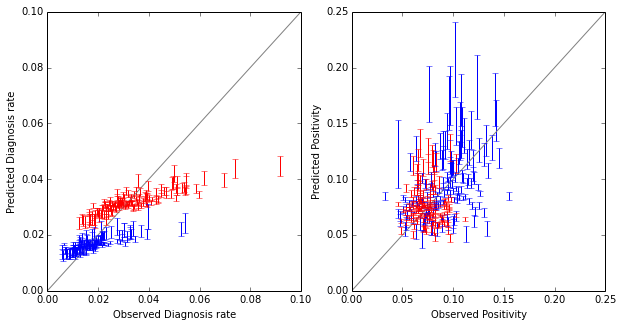

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot([0,1], [0,1], '0.5')
ax2.plot([0,1], [0,1], '0.5')

def plt_ppc(ax, xsample, ysample, index, ci, col): # ci is the confidence interval required, as a %
    ax.errorbar(percentile(xsample, 50, index), 
                percentile(ysample, 50, index), 
                yerr=squeeze(
                    array([[percentile(ysample,50, index) - percentile(ysample, (100.-ci)/2, index)], 
                           [percentile(ysample, (100.+ci)/2, index) - percentile(ysample,50, index)]])
            ), 
                #xerr=array([[percentile(xsample,50) - percentile(xsample, (100.-ci)/2)], [percentile(xsample, (100.+ci)/2) - percentile(xsample,50)]]),
                color=col, linestyle='None'
                )

# positivity
pos_m_laut = diag_m_laut/test_sample_m

# add to plot
plt_ppc(ax1, diag_sample_m, diag_m_laut, 0, 95, 'b')
plt_ppc(ax2, diag_sample_m/test_sample_m, diag_m_laut/test_sample_m, 0, 95, 'b')

# positivity
pos_f_laut = diag_f_laut/test_sample_f

# add to plot
plt_ppc(ax1, diag_sample_f, diag_f_laut, 0, 95, 'r')
plt_ppc(ax2, diag_sample_f/test_sample_f, diag_f_laut/test_sample_f, 0, 95, 'r')

ax1.set_xlim([0,0.1]); ax1.set_ylim([0,0.1])
ax1.set_xlabel('Observed Diagnosis rate')
ax1.set_ylabel('Predicted Diagnosis rate')
ax2.set_xlim([0,0.25]); ax2.set_ylim([0,0.25])
ax2.set_xlabel('Observed Positivity')
ax2.set_ylabel('Predicted Positivity')

## Regional variations in estimated prevalence

The same sampled distributions can also be used to compare the estimated prevalence in different areas of the country.

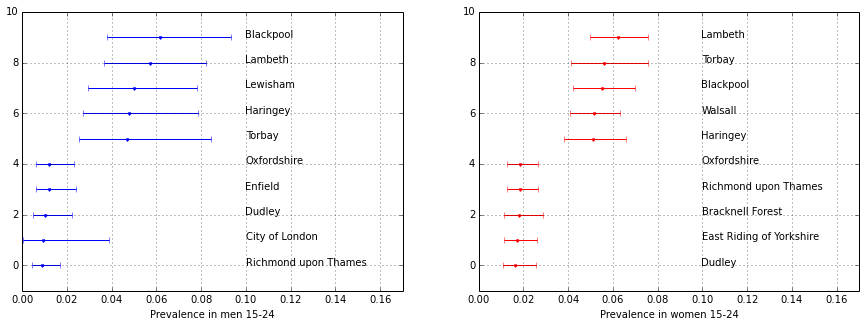

In [8]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

order_m = argsort(percentile(prev_m_laut,50,axis=0)) # order by prevalence in men
order_m = order_m[append(range(0,5),range(146,151))] # Comment-out this line to plot all LAUTS. You will also need to adjust axis sizes.
ax1.errorbar(
    y = range(len(order_m)), 
    x = (percentile(prev_m_laut,50,axis=0))[order_m], 
    xerr=array([percentile(prev_m_laut[:,order_m],50,axis=0) - percentile(prev_m_laut[:,order_m],2.5,axis=0),
            percentile(prev_m_laut[:,order_m],97.5,axis=0) - percentile(prev_m_laut[:,order_m],50,axis=0)]
            ), 
    fmt='.')

ax1.set_ylim(-1, len(order_m)); ax1.set_xlim(0, 0.17)
ax1.set_xlabel('Prevalence in men 15-24')
ax1.grid(True)

order_f = argsort(percentile(prev_f_laut,50,axis=0)) # order by prevalence in women
order_f = order_f[append(range(0,5),range(146,151))] # Comment-out this line to plot all LAUTS. You will also need to adjust axis sizes.
ax2.errorbar(
    y = range(len(order_f)), 
    x = (percentile(prev_f_laut,50,axis=0))[order_f], 
    xerr=array([percentile(prev_f_laut[:,order_f],50,axis=0) - percentile(prev_f_laut[:,order_f],2.5,axis=0),
            percentile(prev_f_laut[:,order_f],97.5,axis=0) - percentile(prev_f_laut[:,order_f],50,axis=0)]
            ), 
    color='r',fmt='.')  

for i in xrange(10):
    ax1.text(0.1, i, alldata.laut[order_m[i]])
    ax2.text(0.1, i, alldata.laut[order_f[i]])

ax2.set_ylim(-1, len(order_f)); ax2.set_xlim(0, 0.17)
ax2.set_xlabel('Prevalence in women 15-24')
ax2.grid(True)


## Prevalence and incidence

Finally, we plot incidence in each sex against prevalence in the other to examine the effect of infection levels in men on the rate of new infections in women, and vice versa. To make the plots easier to interpret, we restrict our attention to 14 regions with the highest and lowest proportion tested and diagnosed and positivity in men and women.

In [9]:
hl = ['Blackpool','Bracknell Forest','Cambridgeshire','County Durham','Dudley', \
    'East Riding of Yorkshire','Hillingdon','Kirklees','Lambeth','Portsmouth', \
    'Sandwell','Torbay','Walsall','West Berkshire']
ofinterest = where(alldata.laut.isin(hl))

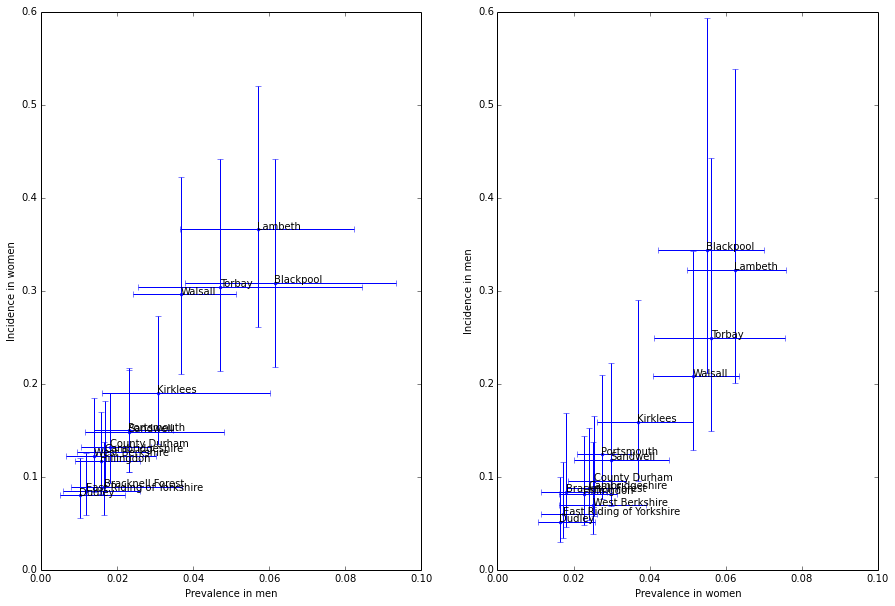

In [10]:
fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

x = percentile(prev_m_laut,50,axis=0)
y = percentile(inc_f_laut,50,axis=0)
xerr = abs(percentile(prev_m_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(inc_f_laut,[2.5, 97.5],axis=0) - y)
ax1.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax1.text(x[i], y[i], alldata.laut[i])

x = percentile(prev_f_laut,50,axis=0)
y = percentile(inc_m_laut,50,axis=0)
xerr = abs(percentile(prev_f_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(inc_m_laut,[2.5, 97.5],axis=0) - y)
ax2.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax2.text(x[i], y[i], alldata.laut[i])

ax1.set_xlim(0,0.1); ax2.set_xlim(0,0.1)
ax1.set_xlabel('Prevalence in men'); ax2.set_xlabel('Prevalence in women')
ax1.set_ylim(0,0.6); ax2.set_ylim(0,0.6)
ax1.set_ylabel('Incidence in women'); ax2.set_ylabel('Incidence in men')



An natural question is why some LAUTs have higher incidence and prevalence than others. One possibility is that higher screening rates in some areas lower prevalence and incidence. To investigate this, plot incidence against screening in men and women:

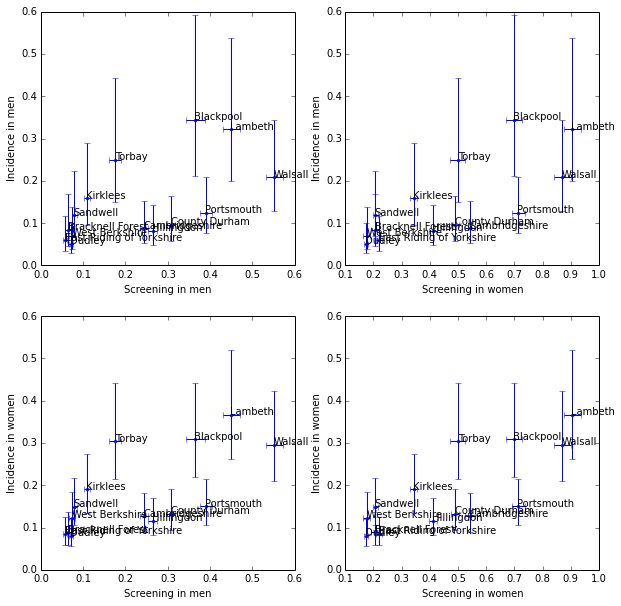

In [24]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x = percentile(scr_m_laut,50,axis=0)
y = percentile(inc_m_laut,50,axis=0)
xerr = abs(percentile(scr_m_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(inc_m_laut,[2.5, 97.5],axis=0) - y)
ax1.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax1.text(x[i], y[i], alldata.laut[i])
ax1.set_xlabel('Screening in men'); ax1.set_ylabel('Incidence in men')

x = percentile(scr_f_laut,50,axis=0)
y = percentile(inc_m_laut,50,axis=0)
xerr = abs(percentile(scr_f_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(inc_m_laut,[2.5, 97.5],axis=0) - y)
ax2.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax2.text(x[i], y[i], alldata.laut[i])
ax2.set_xlabel('Screening in women'); ax2.set_ylabel('Incidence in men')

x = percentile(scr_m_laut,50,axis=0)
y = percentile(inc_f_laut,50,axis=0)
xerr = abs(percentile(scr_m_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(inc_f_laut,[2.5, 97.5],axis=0) - y)
ax3.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax3.text(x[i], y[i], alldata.laut[i])
ax3.set_xlabel('Screening in men'); ax3.set_ylabel('Incidence in women')

x = percentile(scr_f_laut,50,axis=0)
y = percentile(inc_f_laut,50,axis=0)
xerr = abs(percentile(scr_f_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(inc_f_laut,[2.5, 97.5],axis=0) - y)
ax4.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax4.text(x[i], y[i], alldata.laut[i])
ax4.set_xlabel('Screening in women'); ax4.set_ylabel('Incidence in women')

In fact, areas with more screening tend to have higher incidence, although the correlations are fairly weak. We also examine the relationship with prevalence:

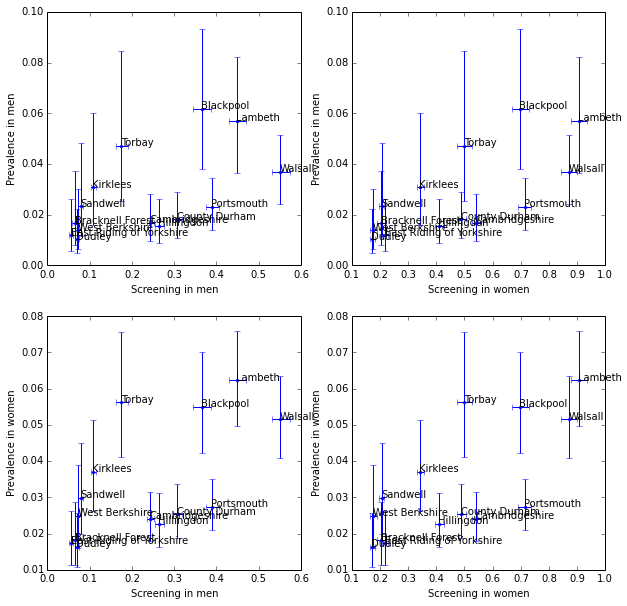

In [25]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x = percentile(scr_m_laut,50,axis=0)
y = percentile(prev_m_laut,50,axis=0)
xerr = abs(percentile(scr_m_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(prev_m_laut,[2.5, 97.5],axis=0) - y)
ax1.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax1.text(x[i], y[i], alldata.laut[i])
ax1.set_xlabel('Screening in men'); ax1.set_ylabel('Prevalence in men')

x = percentile(scr_f_laut,50,axis=0)
y = percentile(prev_m_laut,50,axis=0)
xerr = abs(percentile(scr_f_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(prev_m_laut,[2.5, 97.5],axis=0) - y)
ax2.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax2.text(x[i], y[i], alldata.laut[i])
ax2.set_xlabel('Screening in women'); ax2.set_ylabel('Prevalence in men')

x = percentile(scr_m_laut,50,axis=0)
y = percentile(prev_f_laut,50,axis=0)
xerr = abs(percentile(scr_m_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(prev_f_laut,[2.5, 97.5],axis=0) - y)
ax3.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax3.text(x[i], y[i], alldata.laut[i])
ax3.set_xlabel('Screening in men'); ax3.set_ylabel('Prevalence in women')

x = percentile(scr_f_laut,50,axis=0)
y = percentile(prev_f_laut,50,axis=0)
xerr = abs(percentile(scr_f_laut,[2.5, 97.5],axis=0) - x)
yerr = abs(percentile(prev_f_laut,[2.5, 97.5],axis=0) - y)
ax4.errorbar(x[ofinterest], y[ofinterest], xerr=squeeze(xerr[:,ofinterest]), yerr=squeeze(yerr[:,ofinterest]), fmt='.')
for i in list(ofinterest[0]):
    ax4.text(x[i], y[i], alldata.laut[i])
ax4.set_xlabel('Screening in women'); ax4.set_ylabel('Prevalence in women')

Prevalence is also generally higher in areas with more screening, although the relationship is complex.